In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from skimage.feature import register_translation
import time
from scipy.stats import circmean
from helper import NearFieldPtychographySimulation, tfNearFieldPtychoRecons, tfNearFieldPtychoReconsFromSimulation
import dill

Parameters adapted from https://www.osapublishing.org/oe/abstract.cfm?uri=oe-23-15-19728

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def tensor_clip(t: tf.Tensor, 
                  max_abs: float=1.,
                  min_abs: float=0.):
    
    absval = tf.abs(t)
    abs_clipped = tf.clip_by_value(absval, min_abs, max_abs)
    multiplier = tf.cast(abs_clipped / (absval + 1e-30), 'complex64')
    return t * multiplier

In [4]:
nfsim = NearFieldPtychographySimulation()

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
with open('nfsim.pkl', 'wb') as f:
    dill.dump(nfsim, f)

In [5]:
with open('nfsim.pkl', 'rb') as f:
    nfsim = dill.load(f)

/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


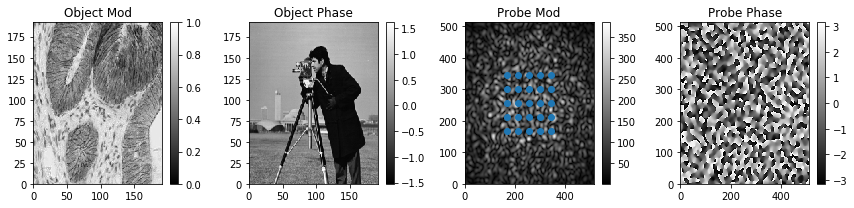

In [6]:
pos_centers = nfsim.scan_params.scan_area_buffer_npix + nfsim.positions + nfsim.obj_params.obj_w_border_npix // 2

plt.figure(figsize=[12, 3])
plot_items = [np.abs(nfsim.obj_true), 
              np.angle(nfsim.obj_true),
              np.abs(nfsim.probe_true),
              np.angle(nfsim.probe_true)]
plot_titles = ['Object Mod', 
               'Object Phase',
               'Probe Mod', 
               'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(1, 4, indx + 1)
    plt.pcolormesh(item, cmap='gray')
    plt.colorbar()
    plt.title(plot_titles[indx])

plt.subplot(1,4,3)
plt.scatter(pos_centers.T[0], pos_centers.T[1])
plt.tight_layout()
plt.show()

In [16]:
nfrecons = tfNearFieldPtychoRecons(diffraction_mods=nfsim.diffraction_mods,
                                   positions=nfsim.positions,
                                   wavelength=nfsim.probe_params.wavelength,
                                   obj_detector_dist=nfsim.det_params.obj_dist,
                                   detector_pixel_pitch=nfsim.det_params.pixel_pitch,
                                   obj_npix=nfsim.obj_params.obj_npix,
                                   probe_npix=nfsim.probe_params.npix,
                                   probe_recons=True, 
                                   batch_size=5,
                                   n_validation_diffs=2)

In [17]:
nfrecons.setLossAndOptimizers(probe_learning_rate=1e1, obj_learning_rate=1e-1)

In [18]:
nfrecons.initSession()

In [19]:
nfrecons.run(patience=5000, max_iters=25000, debug_output_epoch_frequency=100)

epochs training_loss obj_err probe_err patience validation_loss validation_best_loss


100 4.869643e+07      nan      nan     5000 3.909725e+07 3.870989e+07
200 3.507312e+07      nan      nan     5000 3.66599e+07 3.65273e+07
300 4.040979e+07      nan      nan     5000 3.729069e+07 3.613033e+07


KeyboardInterrupt: 

In [132]:
recons_shape = np.array(nfsim.obj_true.shape)
probe_init = np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(np.mean(nfsim.diffraction_mods, axis=0))) / H))

obj_init = (np.random.random(recons_shape) 
            * np.exp(1j * np.random.random(recons_shape) 
                     * np.pi))

In [135]:
tf.reset_default_graph()

batch_size = 5

with tf.device('/gpu:0'):
    tf_obj_real = tf.Variable(np.real(obj_init), dtype='float32')
    tf_obj_imag = tf.Variable(np.imag(obj_init), dtype='float32')
    tf_obj = tf.complex(tf_obj_real, tf_obj_imag)
    
    tf_probe_real = tf.Variable(np.real(probe_init), dtype='float32')
    tf_probe_imag = tf.Variable(np.imag(probe_init), dtype='float32')
    tf_probe = tf.complex(tf_probe_real, tf_probe_imag)
    
    tf_mods = tf.constant(np.fft.fftshift(nfsim.diffraction_mods, axes=(1,2)), 
                           dtype='float32')
    
    
    #tf_view_indices = tf.constant(view_indices, dtype='int32')
    
    #tf_view_indices_expanded = tf.constant(view_expanded, dtype='int32')
    
    #batch_views = tf.ones((batch_size, probe_init.size), dtype='complex64')
    tf_kernel = tf.constant(H, dtype='complex64')

In [137]:

tf_obj_1 = tf.pad(tf_obj, [[nfsim.obj_params.border_npix, nfsim.obj_params.border_npix],
                           [nfsim.obj_params.border_npix, nfsim.obj_params.border_npix]], constant_values=1)

In [138]:
dataset_indices = tf.data.Dataset.range(diffs.shape[0])
dataset_indices = dataset_indices.shuffle(buffer_size=diffs.shape[0])
dataset_indices = dataset_indices.repeat()
dataset_batch = dataset_indices.batch(batch_size, drop_remainder=True)
dataset_batch = dataset_batch.apply(tf.data.experimental.prefetch_to_device('/gpu:0', buffer_size=5))

In [139]:
iterator = dataset_batch.make_one_shot_iterator()

batchi = iterator.get_next()
batch_indices = tf.Variable(tf.zeros(batch_size, dtype=tf.int64), trainable=False)
assign_op = batch_indices.assign(batchi)

batch_mods = tf.gather(tf_mods, batch_indices)

In [142]:
tf_obj_real_pads = []
tf_obj_imag_pads = []
n1 = nfsim.obj_params.obj_w_border_npix
n2 = nfsim.probe_params.npix
for p in nfsim.positions:
    
    padded_real = tf.pad(tf.real(tf_obj_1), [[p[0], n2 - (n1+p[0])],
                                           [p[1], n2 - (n1+p[1])]],
                        constant_values=1)
    padded_imag = tf.pad(tf.imag(tf_obj_1), [[p[0], n2 - (n1+p[0])],
                                           [p[1], n2 - (n1+p[1])]],
                        constant_values=0)
    tf_obj_real_pads.append(padded_real)
    tf_obj_imag_pads.append(padded_imag)

tf_obj_real_pads = tf.stack(tf_obj_real_pads)
tf_obj_imag_pads = tf.stack(tf_obj_imag_pads)
tf_obj_pads = tf.complex(tf_obj_real_pads, tf_obj_imag_pads)
batch_obj_views = tf.gather(tf_obj_pads, batch_indices)

In [144]:
batch_out_wavefronts = (tf.ifft2d(tf.fft2d(batch_obj_views * 
                                          tf_probe) 
                                 / nfsim.probe_params.npix * tf_kernel) 
                        * nfsim.probe_params.npix)

In [145]:
loss = 0.5 * tf.reduce_sum((tf.abs(batch_out_wavefronts) -  batch_mods)**2)

In [146]:
lr_probe_placeholder = tf.placeholder(dtype=tf.float32)
lr_obj_placeholder = tf.placeholder(dtype=tf.float32)

probe_opt = tf.train.AdamOptimizer(learning_rate=lr_probe_placeholder)
probe_min = probe_opt.minimize(loss, var_list=[tf_probe_real, tf_probe_imag])
obj_opt = tf.train.AdamOptimizer(learning_rate=lr_obj_placeholder)
obj_min = obj_opt.minimize(loss, var_list=[tf_obj_real, tf_obj_imag])

In [152]:
init = tf.global_variables_initializer()
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True    
#sess_config.allow_soft_placement=True
session = tf.Session(config=sess_config)
session.run(init)

In [153]:
lossvals = []

In [154]:
pr_obj = session.run(tf_obj)
pr_probe = session.run(tf_probe)

In [155]:
_, __, lossval = session.run([obj_min, probe_min, loss], 
                             feed_dict={lr_obj_placeholder: 1e-2,
                                        lr_probe_placeholder: 1e1})

In [156]:
%%time
for i in range(100):
    _, __, lossval = session.run([obj_min, probe_min, loss], 
                             feed_dict={lr_obj_placeholder: 1e-2,
                                        lr_probe_placeholder: 1e1})
    

CPU times: user 1.12 s, sys: 284 ms, total: 1.4 s
Wall time: 1.2 s


In [209]:
# tensor-Scatter approach
# bs 5: 11 s
# bs 10: 19s

# Stacking the views
# bs 10: 5.57s
# bs 5: 3.7 s

# Scatter nd approach (this is buggy - the gpu version does not handle complex numbers correctly)
# bs 5: 3.2s
# bs 10: 6.16s

# Scatter nd approach for separate real and imaginary parts
# bs 10: 8.23s

In [158]:
%%time
for i_in in range(50000):
    session.run(assign_op)
    _, __, lossval = session.run([obj_min, probe_min, loss],
                                 feed_dict={lr_obj_placeholder: 1e-1,
                                            lr_probe_placeholder: 1e1})
    lossvals.append(lossval)
    
    #if i_in % 100 == 0: session.run([obj_clip_op])#, probe_clip_op])
    if not i_in % 500 == 0: continue

    pr_obj, pr_probe = session.run([tf_obj, tf_probe])
    probe_errs = register_translation(nfsim.probe_true, 
                                   pr_probe,
                                   upsample_factor=10)
    obj_errs = register_translation(nfsim.obj_true, pr_obj, upsample_factor=10)
    print(i_in, probe_errs[1], obj_errs[1], lossval)

0 0.9975778092430778 0.658264703724279 6178043.5
500 0.9979242109936083 0.31954180172266544 3593551.0
1000 0.9978331790081808 0.14928792523593665 3433912.0
1500 0.997718647541455 0.1063093740596555 3154103.2
2000 0.9977415095740173 0.1020247074860321 3001027.5
2500 0.9977583446453524 0.1012372352751237 3168776.2
3000 0.9978219222490979 0.10430298288537482 3632383.0
3500 0.9976352727363607 0.10141663393581103 3196139.2
4000 0.9975027582806602 0.10014242869426469 3091074.2
4500 0.997401445383214 0.10668571975955173 3780979.5
5000 0.9973717119691385 0.10647139630550967 3780922.5
5500 0.997361487178871 0.10753450127973038 4002530.0
6000 0.9973824361507565 0.1050236524425726 3040808.5
6500 0.9974101243357604 0.10501476856665018 2963472.8
7000 0.9973657009094173 0.1098858802239827 2951572.5
7500 0.9972520831905052 0.113857880937396 2834821.0


KeyboardInterrupt: 

In [125]:
recons_obj, recons_probe = session.run([tf_obj, tf_probe])
recons_obj = recons_obj * np.exp(-1j * circmean(np.angle(recons_obj)))
#recons_probe = recons_probe * np.exp(-1j * circmean(np.angle(recons_probe)))


In [87]:
np.angle(recons_obj).max(), np.angle(recons_obj).min()

(2.9005015, -3.1162038)

In [88]:
circmean(np.angle(recons_obj))

1.0634759739502897e-08

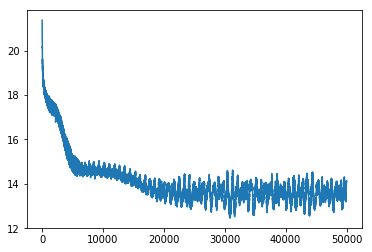

In [126]:
plt.plot(np.log(lossvals))
plt.show()

In [240]:
recons_obj = np.load('vanilla_adam_recons_obj.npy')
recons_probe = np.load('vanilla_adam_recons_probe.npy')
probe_true = np.load('probe_true.npy')

In [127]:
test_shape = np.array(probe_true.shape) // 2 - np.array(probe_true.shape) // 4
s0 = test_shape[0] 

p1 = s0
p2 = -s0

obj_errs_2 = register_translation(obj_true, recons_obj * np.exp(1j * 0), upsample_factor=10)

probe_errs = register_translation(probe_true[p1:p2, p1:p2], recons_probe[p1:p2, p1:p2] * np.exp(1j * 0.95) , upsample_factor=10)
probe_errs_2 = register_translation(probe_true, recons_probe * np.exp(1j * 0.95), upsample_factor=10)
print('Obj')
print(obj_errs_2)
print('Probe')
probe_errs, probe_errs_2

Obj
(array([0., 0.]), 0.003616252976949931, -0.00025093761364635515)
Probe


((array([0., 0.]), 0.15168412285756683, 1.7536622734950087),
 (array([0., 0.]), 0.16999245933073542, 1.7556809723158417))

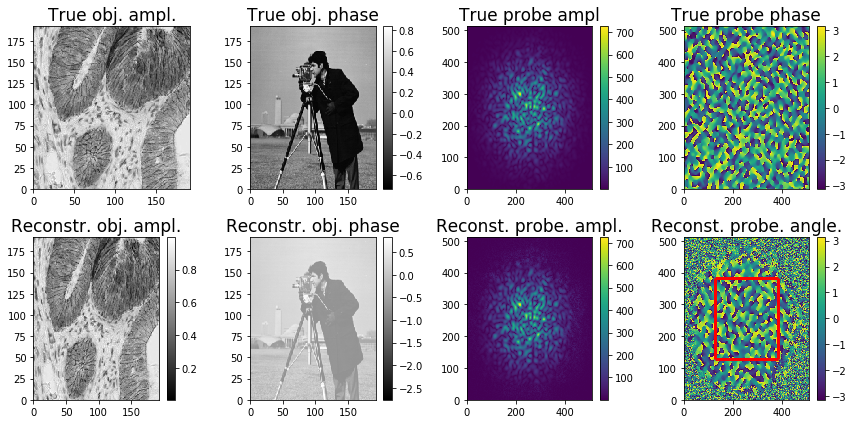

In [128]:
test_obj = obj_true

test_probe = probe_true

plt.figure(figsize=[12, 6])
plt.subplot(2,4,1)
plt.pcolormesh(np.abs(test_obj), cmap='gray')
plt.title('True obj. ampl.', fontsize=17)
plt.subplot(2,4,2)
plt.pcolormesh(np.angle(test_obj), cmap='gray')
plt.title('True obj. phase', fontsize=17)
plt.colorbar()
plt.subplot(2,4,3)
plt.pcolormesh(np.abs(test_probe))
plt.title('True probe ampl', fontsize=17)
plt.colorbar()
plt.subplot(2,4,4)
plt.pcolormesh(np.angle(test_probe))
plt.colorbar()
plt.title('True probe phase', fontsize=17)
plt.subplot(2,4,5)
plt.pcolormesh(np.abs(recons_obj), cmap='gray')
plt.title('Reconstr. obj. ampl.', fontsize=17)
plt.colorbar()
plt.subplot(2,4,6)
plt.pcolormesh(np.angle(recons_obj), cmap='gray')
plt.colorbar()
plt.title('Reconstr. obj. phase', fontsize=17)
plt.subplot(2,4,7)
plt.pcolormesh(np.abs(recons_probe))
plt.colorbar()
plt.title('Reconst. probe. ampl.', fontsize=17)
plt.subplot(2,4,8)
plt.pcolormesh(np.angle(recons_probe))
plt.vlines([s0, probe_npix-s0], s0, probe_npix-s0, colors='red', linewidth=3)
plt.hlines([s0, probe_npix-s0], s0, probe_npix-s0, colors='red', linewidth=3)
plt.title('Reconst. probe. angle.', fontsize=17)
plt.colorbar()
plt.tight_layout()
plt.show()